## IMPORT LIBRARIES

In [2]:
import tensorflow as tf
import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
!pip install mat73
import mat73
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# LOAD ORIGINAL TRAINING DATA

In [7]:
n=5000
import random

fn= f'/content/drive/MyDrive/Colab Notebooks/UNet Model/MW128.mat'
mat = mat73.loadmat(fn)['MW128']
selectindex=random.sample(range(0, mat.shape[2]), n)
ytrain = np.zeros([n,128,128], dtype=np.single)
for i in range(n):
   ytrain[i,:,:]=mat[:,:,selectindex[i]]
mat=[]

In [9]:
fn= f'/content/drive/MyDrive/Colab Notebooks/UNet Model/IR128.mat'
mat = mat73.loadmat(fn)['IR128']
xtrain1 = np.zeros([n,128,128], dtype=np.uint8)
for i in range(n):
   xtrain1[i,:,:]=mat[:,:,selectindex[i]]
mat=[]

In [10]:
from scipy import ndimage, misc
fn= f'/content/drive/MyDrive/Colab Notebooks/UNet Model/RAIN128.mat'
mat = mat73.loadmat(fn)['RAIN128']
xtrain2 = np.reshape(mat,[1,128,128])
xtrain2 = np.repeat(xtrain2, n, axis=0)
xtrain2.shape

(5000, 128, 128)

In [11]:
dataset=np.stack([xtrain1,xtrain2,ytrain],-1)
print(dataset.shape)

(5000, 128, 128, 3)


In [12]:
xtrain1, xtrain2, ytrain = [], [], []

In [13]:
train_size =4000
test_size =1000
train= dataset[:train_size,...]
test = dataset[train_size:train_size+test_size,...]

np.save(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/train_dataset.npy',train)
np.save(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/test_dataset.npy',test)
dataset=[]

# LOAD PROCESSED TRAINING DATA



In [16]:
## New Pipeline (disconect the runtime and run this pipline instead of old pipeline to compare)
train = np.load(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/train_dataset.npy')
test = np.load(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/test_dataset.npy')
print(train.shape)

(4000, 128, 128, 3)


In [17]:
BATCH_SIZE = 8
def data_generator(data):
    for i in range(data.shape[0]):
        yield data[i]

def load(input):
  input_image_ir = tf.convert_to_tensor(tf.reshape((input[...,0]-1)/254.0,[128,128,1]))
  input_image_rain = tf.convert_to_tensor(tf.reshape((input[..., 1] - 1) / 254.0, [128, 128, 1]))
  real_image = tf.convert_to_tensor(tf.reshape(input[...,2],[128,128,1]))
  input_image_ir = tf.cast(input_image_ir, tf.float32)
  input_image_rain = tf.cast(input_image_rain, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image_ir, input_image_rain, real_image

def load_image_train(image_file):
  input_image_ir, input_image_rain, real_image = load(image_file)
  return (input_image_ir, input_image_rain), real_image

def load_image_test(image_file):
  input_image_ir, input_image_rain, real_image = load(image_file)
  return (input_image_ir, input_image_rain), real_image

train_dataset = tf.data.Dataset.from_generator(lambda: data_generator(train), output_types=tf.float32)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(lambda: data_generator(test), output_types=tf.float32)
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [18]:
test_dataset

<_BatchDataset element_spec=((TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

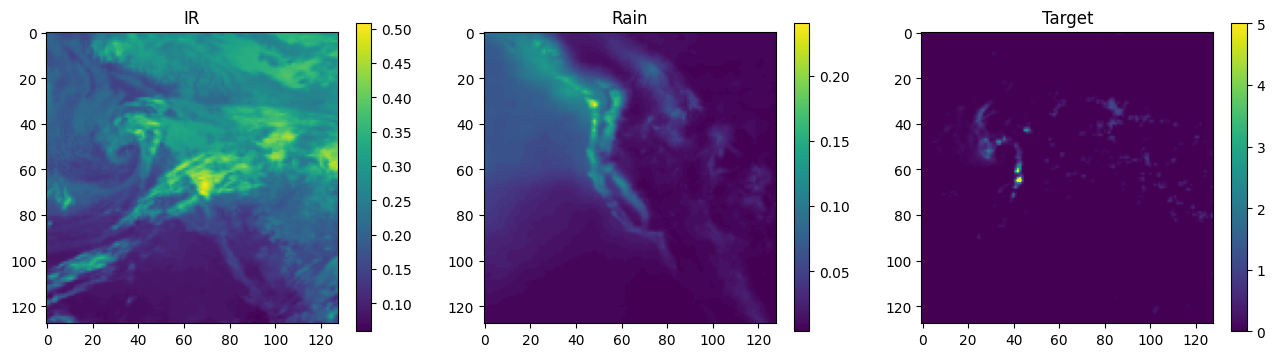

0.0


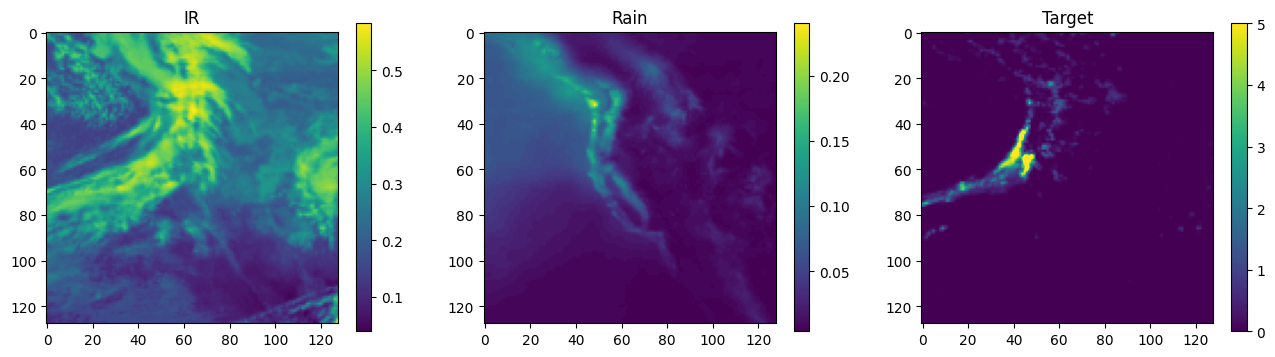

0.0


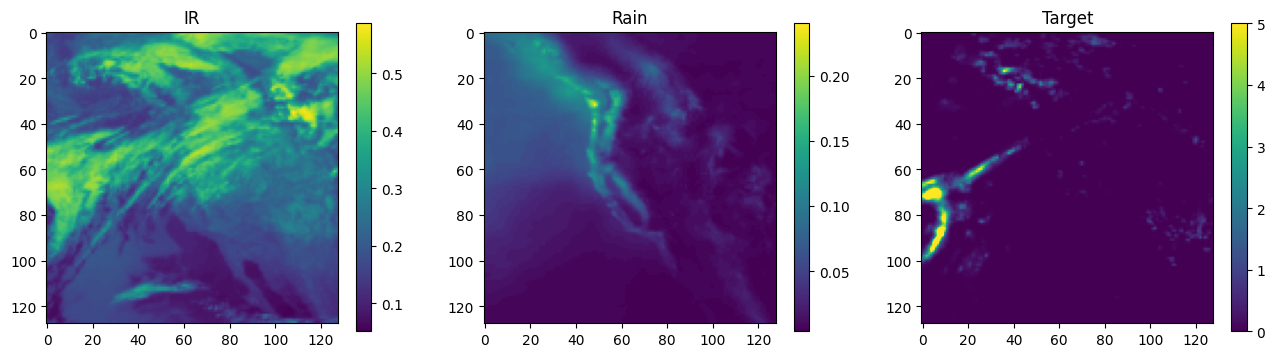

0.0


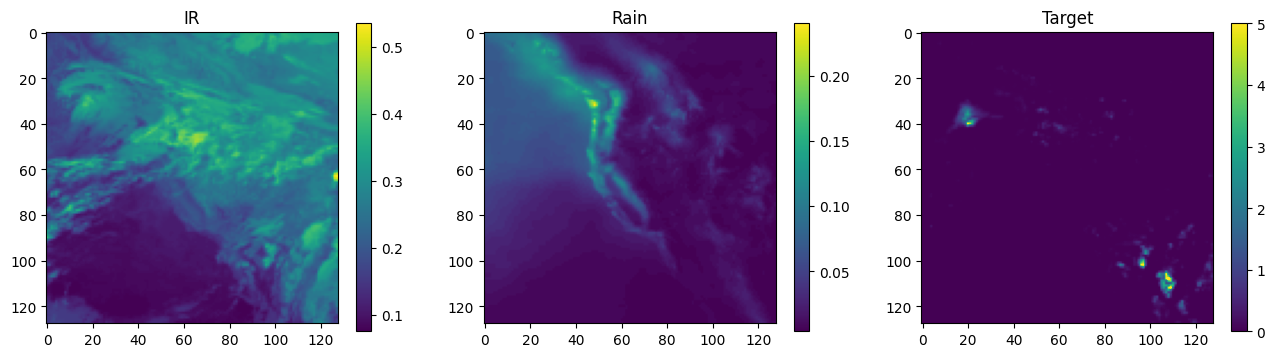

0.0


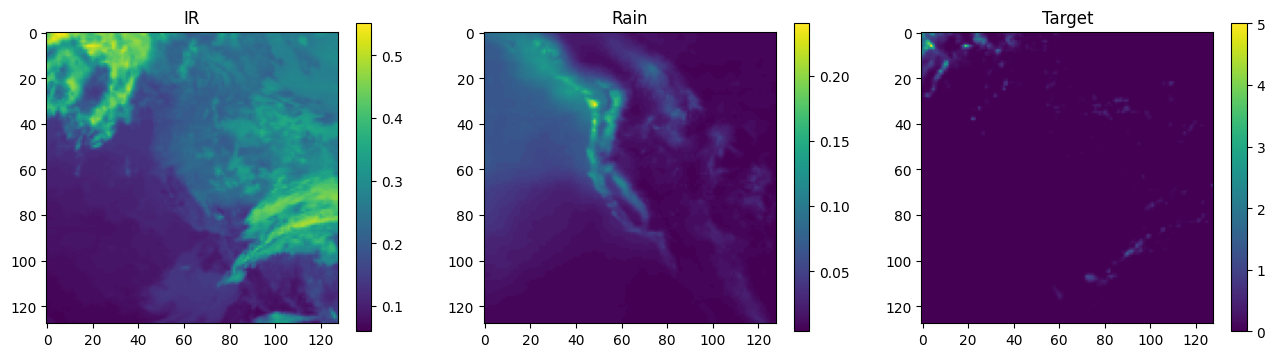

0.0


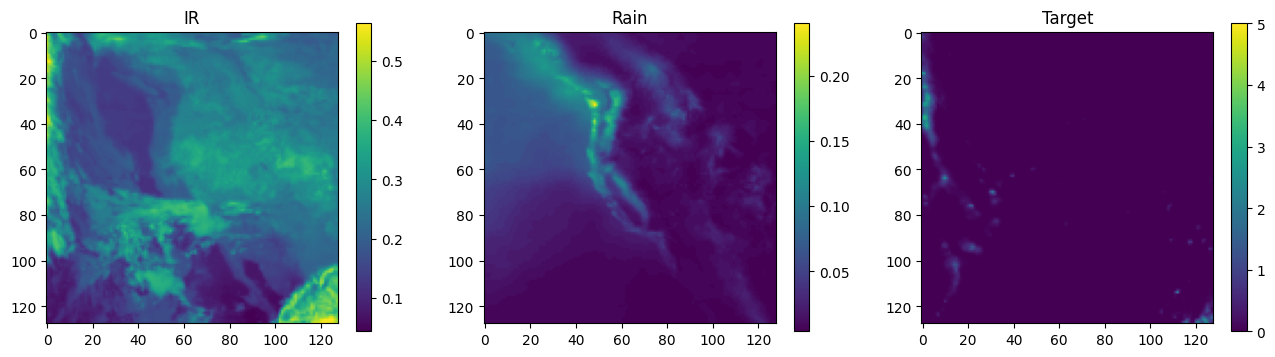

0.0


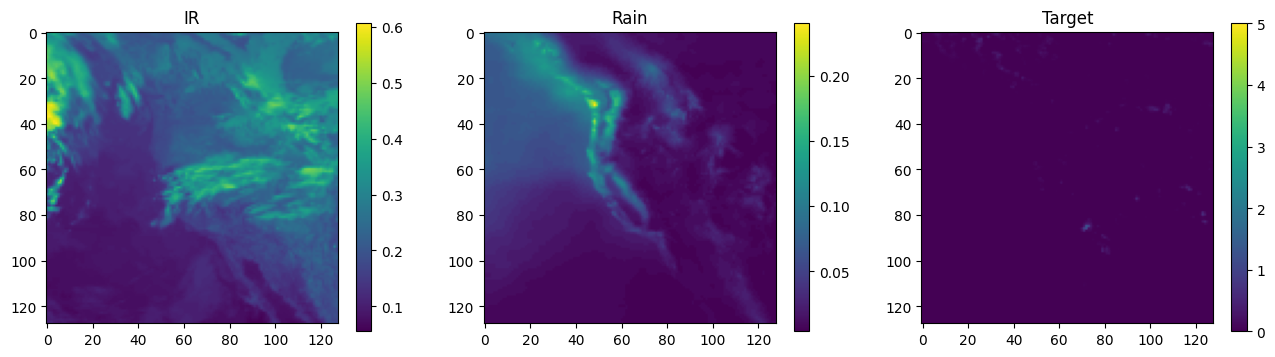

0.0


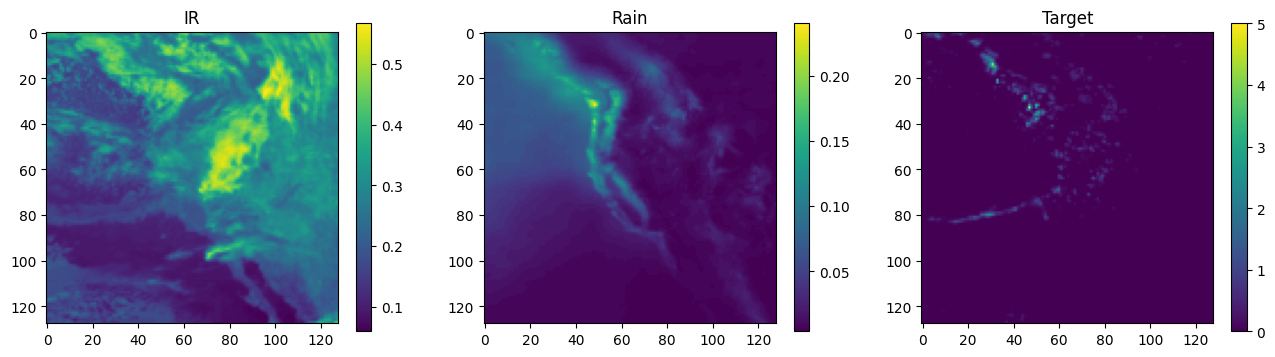

0.0


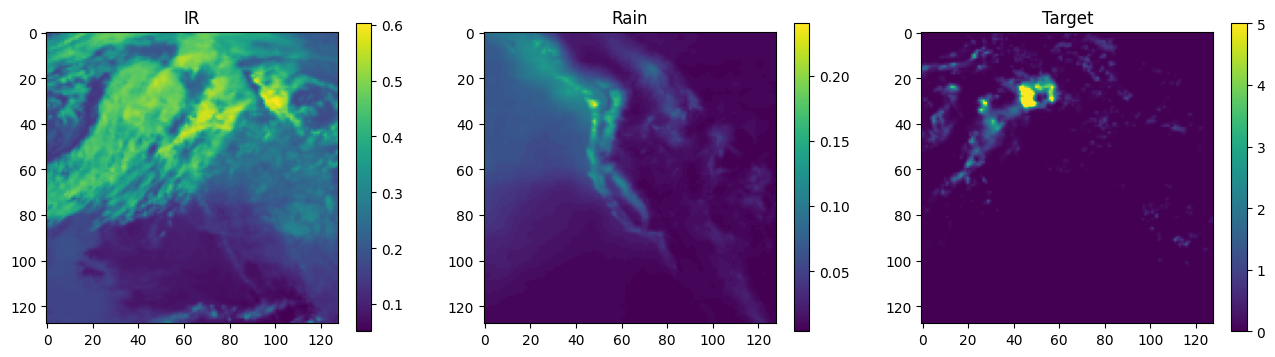

0.0


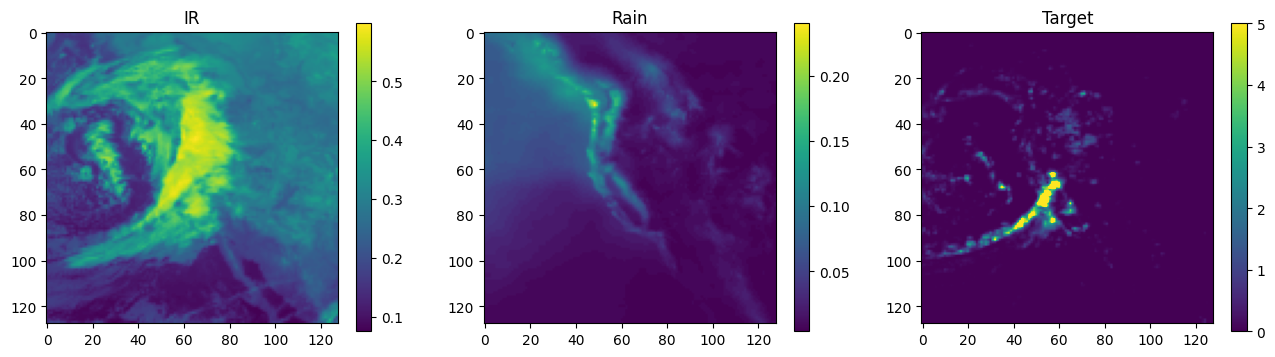

0.0


In [19]:
##Display images
for (input_image_ir, input_image_rain), target_image in test_dataset.take(10):
    # Display the input and target images side-by-side
    fig = plt.figure(figsize=(16, 4))

    # Display the IR image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image_ir[0,...,0])
    plt.title('IR')
    plt.colorbar()

    #Display the Rain image
    plt.subplot(1, 3, 2)
    plt.imshow(input_image_rain[0,...,0])
    plt.title('Rain')
    plt.colorbar()

    #Display the Target image
    plt.subplot(1, 3, 3)
    plt.imshow(target_image[0,...,0])
    plt.title('Target')
    plt.colorbar()
    plt.clim(0,5)
    plt.show()
    print(np.min(target_image[0,...,0]))

##BUILD THE UNET MODEL

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.models import Model

# Define the input shape for 2D data
input_shape_ir = (128, 128, 1)
input_shape_rain = (128, 128, 1)

# Define input layer
input_ir = Input(shape=input_shape_ir, name='input_ir')
input_rain = Input(shape=input_shape_rain, name='input_rain')

input_data = concatenate([input_ir, input_rain], axis=-1)


# U-Net Encoder
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_data)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Bottleneck layer
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

# U-Net Decoder
up3 = UpSampling2D(size=(2, 2))(conv4)
up3 = concatenate([conv3, up3], axis=-1)
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3)
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

up2 = UpSampling2D(size=(2, 2))(conv5)
up2 = concatenate([conv2, up2], axis=-1)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

up1 = UpSampling2D(size=(2, 2))(conv6)
up1 = concatenate([conv1, up1], axis=-1)
conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

# Output layer for precipitation rate estimation
output_data = Conv2D(1, (1, 1), activation='linear')(conv7)

# Define the model
model = Model(inputs=[input_ir, input_rain], outputs=output_data)

# Compile the model (choose an appropriate optimizer and loss function)
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])


In [ ]:
#transformer model, diffusion model and GAN

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ir (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_rain (InputLayer)     [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 128, 128, 2)          0         ['input_ir[0][0]',            
                                                                     'input_rain[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1216      ['concatenate[0][0]']     

## TRAIN THE UNET MODEL

In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20,batch_size=8)

Epoch 1/20
500/500 [==============================] - 72s 112ms/step - loss: 0.2390 - mae: 0.1339 - val_loss: 0.2180 - val_mae: 0.1458
Epoch 2/20
500/500 [==============================] - 57s 114ms/step - loss: 0.2192 - mae: 0.1248 - val_loss: 0.2006 - val_mae: 0.1126
Epoch 3/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2049 - mae: 0.1203 - val_loss: 0.1948 - val_mae: 0.1196
Epoch 4/20
500/500 [==============================] - 57s 114ms/step - loss: 0.1921 - mae: 0.1169 - val_loss: 0.1811 - val_mae: 0.1118
Epoch 5/20
500/500 [==============================] - 56s 113ms/step - loss: 0.1789 - mae: 0.1128 - val_loss: 0.1869 - val_mae: 0.1183
Epoch 6/20
500/500 [==============================] - 56s 112ms/step - loss: 0.1648 - mae: 0.1087 - val_loss: 0.1694 - val_mae: 0.1215
Epoch 7/20
500/500 [==============================] - 55s 111ms/step - loss: 0.1510 - mae: 0.1047 - val_loss: 0.1551 - val_mae: 0.1147
Epoch 8/20
500/500 [==============================] - 5

In [15]:
model.save(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## PLOT THE LEARNING CURVE

In [22]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# summarize history for loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

## TEST SOME PRELIMARY RESULTS WITH TEST DATASET

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# load model
import keras
model=keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/model1.h5')


In [25]:
test = np.load(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/test_dataset.npy')

In [26]:
BATCH_SIZE = 1
def data_generator(data):
    for i in range(data.shape[0]):
        yield data[i]

def load(input):
  input_image_ir = tf.convert_to_tensor(tf.reshape((input[..., 0] - 1) / 254.0, [128, 128, 1]))
  input_image_rain = tf.convert_to_tensor(tf.reshape((input[..., 1] - 1) / 254.0, [128, 128, 1]))
  real_image = tf.convert_to_tensor(tf.reshape(input[...,2],[128,128,1]))
  input_image_ir = tf.cast(input_image_ir, tf.float32)
  input_image_rain = tf.cast(input_image_rain, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image_ir, input_image_rain, real_image

def load_image_train(image_file):
  input_image_ir, input_image_rain, real_image = load(image_file)
  return (input_image_ir, input_image_rain), real_image

def load_image_test(image_file):
  input_image_ir, input_image_rain, real_image = load(image_file)
  return (input_image_ir, input_image_rain), real_image

test_dataset = tf.data.Dataset.from_generator(lambda: data_generator(test), output_types=tf.float32)
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [27]:
import numpy as np
# Evaluate the model with the test dataset
loss, mae = model.evaluate(test_dataset, verbose=0)

# Calculate the correlation coefficient
y_true = []  # Ground truth precipitation rates
y_pred = []  # Predicted precipitation rates

for (input_image_ir, input_image_rain), real_image in test_dataset:
    predictions = model.predict([input_image_ir, input_image_rain], verbose=0)
    y_true.extend(real_image.numpy().flatten())
    y_pred.extend(predictions.flatten())

corr_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
print(f"Test Loss (MSE): {loss}, MAE: {mae}, Correlation: {corr_coefficient}")

Test Loss (MSE): 0.3213876783847809, MAE: 0.11314447969198227, Correlation: -0.24595860311960685


In [ ]:
#subplot - IR, prediction and target

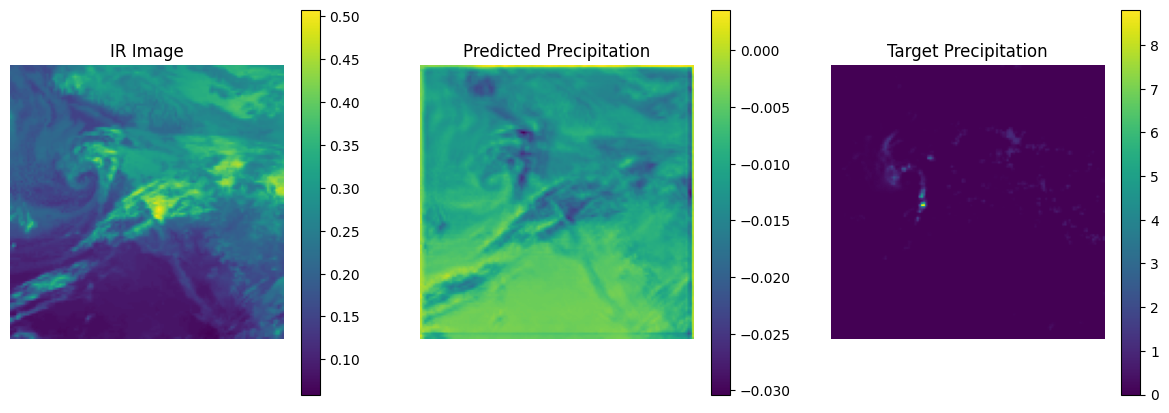

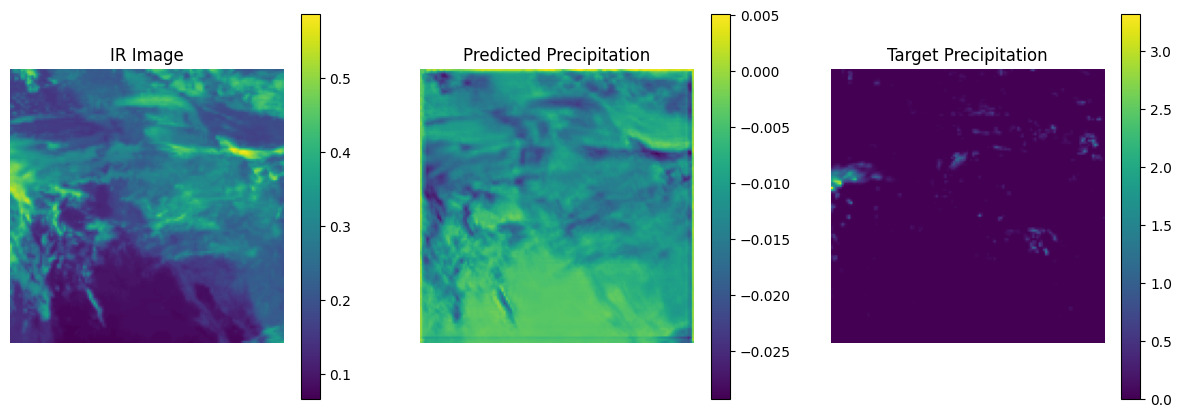

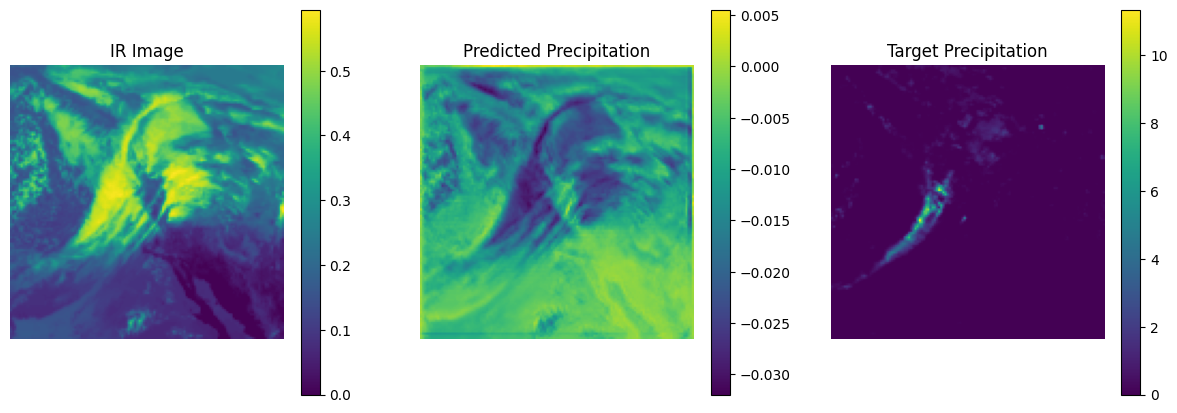

Test Loss (MSE): 0.3213876783847809, MAE: 0.11314447969198227, Correlation: -0.23079872568485474


In [30]:
# Evaluate the model with the test dataset
loss, mae = model.evaluate(test_dataset, verbose=0)

# Calculate the correlation coefficient
y_true = []  # Ground truth precipitation rates
y_pred = []  # Predicted precipitation rates

# Get a single batch from the test dataset
for (input_image_ir, input_image_rain), real_image in test_dataset.take(3):
    predictions = model.predict([input_image_ir, input_image_rain], verbose=0)
    y_true.extend(real_image.numpy().flatten())
    y_pred.extend(predictions.flatten())

    # Plot IR, prediction, and target images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # IR Image
    im = axes[0].imshow(input_image_ir[0, ..., 0])
    axes[0].set_title('IR Image')
    axes[0].axis('off')
    fig.colorbar(im, ax=axes[0])

    # Predicted Image
    im = axes[1].imshow(predictions[0, ..., 0])
    axes[1].set_title('Predicted Precipitation')
    axes[1].axis('off')
    fig.colorbar(im, ax=axes[1])

    # Target Image
    im = axes[2].imshow(real_image[0, ..., 0])
    axes[2].set_title('Target Precipitation')
    axes[2].axis('off')
    fig.colorbar(im, ax=axes[2])

    plt.show()

corr_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
print(f"Test Loss (MSE): {loss}, MAE: {mae}, Correlation: {corr_coefficient}")


In [ ]:
# Set a precipitation threshold (e.g., 0.5) to convert predictions to binary values
threshold = 0.1

# Convert predictions to binary using the threshold
y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred]
y_true_binary = [1 if ytrue >= threshold else 0 for ytrue in y_true]

# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
TP = sum((y_true_binary[i] == 1) and (y_pred_binary[i] == 1) for i in range(len(y_true)))
FP = sum((y_true_binary[i] == 0) and (y_pred_binary[i] == 1) for i in range(len(y_true)))
TN = sum((y_true_binary[i] == 0) and (y_pred_binary[i] == 0) for i in range(len(y_true)))
FN = sum((y_true_binary[i] == 1) and (y_pred_binary[i] == 0) for i in range(len(y_true)))

# Calculate Probability of Detection (POD), False Alarm Ratio (FAR), and Critical Success Index (CSI)
POD = TP / (TP + FN)
FAR = FP / (FP + TP)
CSI = TP / (TP + FN + FP)

print(f"Test Loss (MSE): {loss}, Test MAE: {mae}, Correlation: {corr_coefficient}")
print(f"Probability of Detection (POD): {POD}")
print(f"False Alarm Ratio (FAR): {FAR}")
print(f"Critical Success Index (CSI): {CSI}")

Test Loss (MSE): 0.15227550268173218, Test MAE: 0.0952053964138031, Correlation: 0.8312742119831342
Probability of Detection (POD): 0.7427388621951968
False Alarm Ratio (FAR): 0.4624758000915356
Critical Success Index (CSI): 0.45315517931346394
